# CS440/ECE448 Spring 2023
# MP10: Markov decision processes

The first thing you need to do is to download this file: <a href="mp10.zip">mp10.zip</a>.  It has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp10_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `solution.json`: This file contains the solutions for the visible test cases, in <a href="https://docs.python.org/3/library/json.html">JSON</a> format.  If the instructions are confusing you, please look at this file, to see if it can help to clear up your confusion.
* `models`: This directory contains two MDP models. Especially, `models/model_small.json` is exactly the same as the one presented in the slides. If the slides are not available yet when you are doing this MP, please refer to <a href="https://courses.engr.illinois.edu/ece448/sp2022/slides/lec32.pdf"> the slides for spring 2022</a>.
* `utils.py`: This is an auxiliary program that you can use to load the model and visualize it.

Please note that there is no extra packages that you should be using except for NumPy. (**Using exsiting MDP libraries would result in score 0!**)

This file (`mp10_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">The MDP environment</a>
1. <a href="#section2">Value iteration</a>
1. <a href="#grade">Grade Your Homework</a>


<a id='section1'></a>
## The MDP environment
In this MP, you will implement the value iteration algorithm introduced in the class. The MDPs you will work on are similar to the grid world example mentioned in the class, but with __state-dependent transition and reward model__.

### Loading the MDP model
Helper functions are provided in ```utils.py```. Two predefined MDP models are given in ```models```. Please note that ```models/small.json``` defines exactly the same MDP model presented in the lecture, and you can use the intermediate results in the slides to debug your implementation. With function ```load_MDP(filename)```, you can load a MDP model as follows.

In [4]:
import utils
model = utils.load_MDP('models/model_small.json')
### To load the other one, uncomment the following
# model = utils.load_MDP('models/model_large.json')

The loaded model ```model``` fully defines the MDP model as follows.

In [5]:
print(model.M, model.N)
print(model.gamma)
print(model.W.shape)
print(model.T.shape)
print(model.R.shape)
print(model.D.shape)
print('\n#################\n')
help(model.visualize)

3 4
1.0
(3, 4)
(3, 4)
(3, 4)
(3, 4, 3)

#################

Help on method visualize in module utils:

visualize(U=None) method of utils.GridWorld instance
    This function visualizes the shape, the wall, and the terminal states of the environment. If a utility function U is provided, then it visualizes the utility function instead.



Now, we explain the elements of the loaded model.

### The states
Simillar to the grid world presented in the class, the environment is a grid world with $M \times N$ cells. $M$ and $N$ are accessible via ```model.M``` and ```model.N```. In the following, cell $(r, c)$ refers to the cell at the $r$-th row and $c$-th column. Each cell represents a state of the MDP.

### The wall
The $M \times N$ boolean matrix ```model.W``` defines the wall in the environment. If ```model.W[r, c] == True```, then the cell $(r, c)$ is occupied by the wall.

### The rewards
The $M \times N$ boolean matrix ```model.T``` defines the terminal states. ```model.T[r, c] == True``` if the cell $(r, c)$ is a _terminal state_, and ```T[r, c] == False``` otherwise.

The $M \times N$ matrix ```model.R``` defines the rewards. ```model.R[r, c]``` is the reward that the agent can get if it reaches the cell $(r, c)$. For terminal states, the reward will be either $+1$ or $-1$. For non-terminal states, the reward will be a small negative number.

Furthermore, ```model.gamma``` is the discount factor $\gamma$ you should use when computing the dicounted reward.

### The actions
At each non-terminal cell $(r, c)$, there are four available actions for the agent: move __left__, __up__, __right__, or __down__. However, due to environmental disturbances, the agent cannot always move as intended. Instead, an $M \times N \times 3$ numpy array is provided to define the movement and can be accessed as ```model.D```. Specifically, the actual movement of the agent will be along the intended direction with probability ```model.D[r, c, 0]```, and will be at the right angles to the intended direction with probability ```model.D[r, c, 1]``` (counter-clockwise) $+$ ```model.D[r, c, 2]``` (clockwise). It is guaranteed that the summation of these three probabilites is one. The next state of the agent will be the next cell along the actual moving direction. However, if the actual movement of the agent results in a collision with the boundary of environment or the wall, the agent will stay in the current cell.

### Visualization
We also provide a helper function for visualizing the environment, and the utility function. To use it, please run the following. In the figure, "x" marks a cell that is occupied by the wall. "+1" and "-1" mark the terminal states and their rewards.

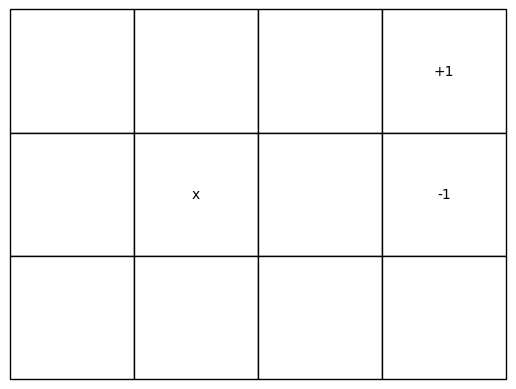

In [6]:
model.visualize()

You can also visualize the utility function. You can visualize the utility function at each iteration to see how it is being updated, which is helpful for debug.

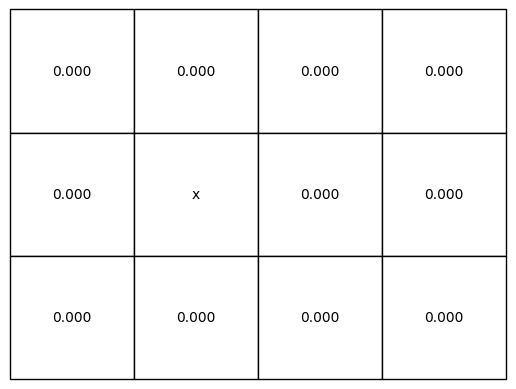

In [7]:
import numpy as np
U = np.zeros([model.M, model.N])
model.visualize(U)

### Coordinate system
Please be aware of the coordinate system we will use in this MP. In the above visualization, the cell at the upper-left corner is $(0, 0)$, the upper-right is $(0, 3)$, and bottom-left is $(2, 0)$. Moving up means moving from $(r, c)$ to $(r-1, c)$, moving right means from $(r, c)$ to $(r, c+1)$, and so on.

<a id='section2'></a>
## Value iteration
As stated in the lecture, the utility of a state $s$ is the best possible expected sum of discounted rewards and denoted by $U(s)$. With value iteration, we can compute this function $U$. The algorithm proceeds as follows.

We start with iteration $i = 0$ and simply initialize $U_i(s) = 0$ for all $s$. Then at each iteration, we update $U$ as follows
$$
U_{i+1}(s) = R(s) + \gamma \max_{a} \sum_{s^\prime} P(s^\prime | s, a) U_{i}(s^\prime).
$$

We keep doing this until convergence, i.e., when $|U_{i+1}(s) - U_i(s)| < \epsilon$ for all $s$, where $\epsilon > 0$ is a constant.

In order to implement the algorithm, you need to complete the following functions in ```submitted.py```.

### Computing the transition matrix $P$

First, notice that the transition matrix $P(s' | s, a)$ will be called many times, and it will not change during the value iteration. Thus, it makes sense to precompute it before doing the value iteration. To this end, you need to complete the function ```compute_transition_matrix()```. This function takes in the MDP model ```model``` and computes the transition "matrix", which is actually an $M \times N \times 4 \times M \times N$ numpy array ```P```. In this function, you need to consider each state $(r, c)$ and each action $a \in \{0\text{ (left)}, 1\text{ (up)}, 2\text{ (right)}, 3\text{ (down)}\}$. ```P[r, c, a, r', c']``` should be the probability that the agent will move from cell ```(r, c)``` to ```(r', c')``` if it takes action ```a```. Especially, if ```(r, c)``` is a terminal state, you can simply set ```P[r, c, :, :, :] = 0```, i.e., the probability that the agent move from a terminal state to any state (including itself) is $0$, since once the agent reaches a terminal state, the game is over.

You may notice that the transition matrix ```P``` is very sparse, i.e., most of its elements are zeros. Better data structre such as sparse matrices can be used to improve the efficiency. But in this MP, we simply use a regular numpy array.

In [31]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.compute_transition_matrix)

Help on function compute_transition_matrix in module submitted:

compute_transition_matrix(model)
    Parameters:
    model - the MDP model returned by load_MDP()
    
    Output:
    P - An M x N x 4 x M x N numpy array. P[r, c, a, r', c'] is the probability that the agent will move from cell (r, c) to (r', c') if it takes action a, where a is 0 (left), 1 (up), 2 (right), or 3 (down).



If you loaded the ```'models/model_small.json'``` MDP in the previous section, you can check some cells in the computed transition matrix to see if it is correct. For example, in the following, we check ```P[1, 0, 2, :, :]```. Recall that this should the probability distribution of the next state if the agent takes the action $2$ (right) at cell $(1, 0)$. Please also keep in mind that cell $(1, 1)$ is occupied by the wall. So, with probability $0.1$ the agent will move up to $(0, 0)$; with probability $0.1$ the agent will move down to $(2, 0)$; with probability $0.8$, it will move as intended (right) but will cause a collision to the wall, and thus the agent will stay at $(1, 0)$ with probability $0.8$.

[[0.1 0.  0.  0. ]
 [0.8 0.  0.  0. ]
 [0.1 0.  0.  0. ]]


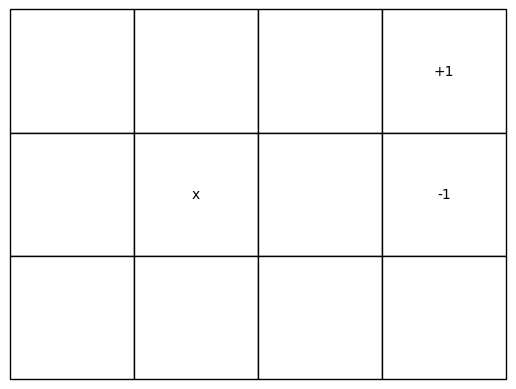

In [53]:
P = submitted.compute_transition_matrix(model)
print(P[1, 0, 2, :, :])
model.visualize()

### Updating the utility function

Then, you need to complete the function ```update_utility```, which takes in the current utility function ```U_current``` (corresponding to the $U_i$ in the above equation) and computes the updated utility function ```U_next``` (corresponding to the $U_{i+1}$ in the above equation). This function should implement the update rule (the equation) in the value iteration algorithm.

In [54]:
importlib.reload(submitted)
help(submitted.update_utility)

Help on function update_utility in module submitted:

update_utility(model, P, U_current)
    Parameters:
    model - The MDP model returned by load_MDP()
    P - The precomputed transition matrix returned by compute_transition_matrix()
    U_current - The current utility function, which is an M x N array
    
    Output:
    U_next - The updated utility function, which is an M x N array



Since we have represented the transition ```P``` and utility ```U_current``` as numpy arrays. The best way to implement this function is to use vectorization. That is, we can rewrite the update rule as some matrix operations and then use numpy's builtin functions to compute them. For example, the summation in the equation is actually an inner product of $P$ and $U_i$. Using numpy's ```dot``` function to compute this inner product is much faster than implementing it as a for loop. However, using vectorization is totally optional for you. The efficiency of your program will not contribute to your score. You will not get any extra credit even if you indeed use vectorization. So feel free to use for loop since it is much easier to implement.

### Putting them together

Now, you are ready to complete the ```value_iteration``` function, which should first compute the ```P``` but calling ```compute_transition_matrix``` and then keeps calling ```update_utility``` until convergence. Please keep in mind that the convergence criterion is $|U_{i+1}(s) - U_i(s)| < \epsilon$ for all $s$. In this MP, please use $\epsilon = 10^{-3}$. In ```submitted.py```, you can find a predefined variable ```epsilon = 1e-3```. Also, please stop the program after a specifc number of iteration even if it has not converged. 100 iterations should be sufficient for all the tests in this MP.

In [59]:
importlib.reload(submitted)
help(submitted.value_iteration)

Help on function value_iteration in module submitted:

value_iteration(model)
    Parameters:
    model - The MDP model returned by load_MDP()
    
    Output:
    U - The utility function, which is an M x N array



For the purpose of debugging, you can visualize the utility function at each iteration using the provided ```model.visualize(U_current)``` function to see how the utility is being updated. You can also compare your utility function to the ground truth presented in the slides. For example, the following code visualize the computed utility. You can compare it to the one in the slides.

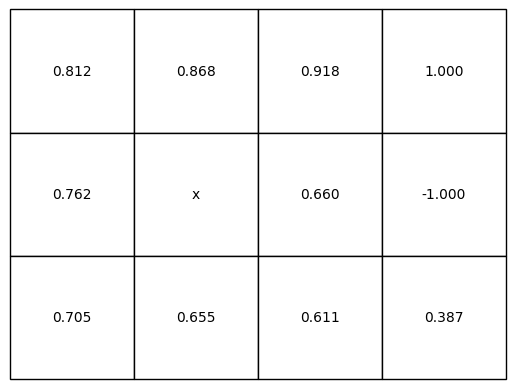

In [60]:
importlib.reload(submitted)
U = submitted.value_iteration(model)
model.visualize(U)

<a id='grade'></a>
## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

In [61]:
!python grade.py

....
----------------------------------------------------------------------
Ran 4 tests in 0.025s

OK


If you got any 'E' marks, it means that your code generated some runtime errors, and you need to debug those.

If you got any 'F' marks, it means that your code ran without errors, but that it generated results that are different from the solutions in `solutions.json`.  Try debugging those differences.

If neither of those things happened, and your result was a series of dots, then your code works perfectly.  

If you're not sure, you can try running grade.py with the -j option.  This will produce a JSON results file, in which the best score you can get is 60.

Now you should try uploading `submitted.py` to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

Gradescope will run the same visible tests that you just ran on your own machine, plus some additional hidden tests.  It's possible that your code passes all the visible tests, but fails the hidden tests.  If that happens, then it probably means that you hard-coded a number into your function definition, instead of using the input parameter that you were supposed to use.  Debug by running your function with a variety of different input parameters, and see if you can get it to respond correctly in all cases.

Once your code works perfectly on Gradescope, with no errors, then you are done with the MP.  Congratulations!